In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.


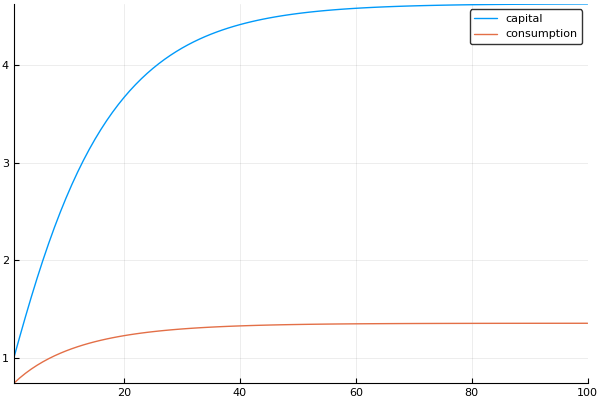

In [152]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [153]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [216]:
u_crra(c, γ) = begin
    if (c <= 0)
        warn("u_crra_prime")
        return -1000000.
        else
        return c^(1-γ)/(1-γ)
    end
end

u_crra_prime(c, γ) = begin
    if (c <= 0)
        #warn("u_crra_prime")
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
       #warn("u_crra_prime_inv")
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        warn("f")
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        warn("f_prime")
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [217]:
using JuMP
using Ipopt

m = Model(solver=IpoptSolver(print_level=3, max_iter=500));

I define the deep parameters variables and give the the correct starting values:

In [218]:
#@variable(m, 0 <= β <= 1, start = 0.95)
#@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
#@variable(m, A >= 0, start = 1)
@variable(m, 100 >= γ >= 1, start = 2);

@variable(m, β == 0.95)
@variable(m, A == 1)
@variable(m, δ == 0.05)

δ

I define a grid on capital, $K$, with 12 nodes, and evaluate the spline polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [219]:
using BasisMatrices
global const params = SplineParams(linspace(0.2*k_stst, 2*k_stst, 10), 0, 3)
basis = Basis(params)
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Ψprime = BasisMatrix(basis, Expanded(), K, 1).vals[1]
Ψprimeprime = BasisMatrix(basis, Expanded(), K, 2).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1]
Φprime = BasisMatrix(basis, Expanded(), dataK, 1).vals[1];

The policy function is approximated by 12 cubic splines on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

In [220]:
@variable(m, θ[1:length(K)], start = 0);

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [221]:
function interpV(x, values...) #x is the point of evaluation, values are on the grid
    return (evalbase(params, [x], 0) * collect(values))[1]
end

interpV (generic function with 1 method)

I register all user-defined functions with JuMP for automatic differentiation:

In [222]:
JuMP.register(m, :interpV, 1+length(K), interpV, autodiff=true)
JuMP.register(m, :u_crra, 2, u_crra, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

And I do not initialize $\theta$ at the true values:

In [223]:
#b2 = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
#ν  = Ψ \ (BasisMatrix(b2, Expanded(), K).vals[1] * [-15.112, 2.69213, -0.640543, 0.208069, -0.0777003, 0.0304588, -0.0123556, 
#        0.00602886, -0.00329544, 0.00114639])

#for i in 1:length(K)
#    setvalue(θ[i], ν[i])
#end

but with a myopic first guess, that leaves tomorrow's capital within the grid $K$:

In [224]:
ν  = Ψ \ u_crra.(f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 1., getvalue(γ)) # eat almost everything, myopic!

for i in 1:length(K)
    setvalue(θ[i], ν[i])
end

The Bellman equation is accompanied by two constraints on the shape of the value function:

In [225]:
@NLconstraint(m, increasing[i=1:length(K)], sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) >= 0)
@NLconstraint(m, concave[i=1:length(K)], sum(Ψprimeprime[i, k] * θ[k] for k in 1:length(K)) <= 0)

@NLconstraint(m, EE[i=1:length(K)], sum(Ψ[i, k] * θ[k] for k in 1:length(K)) == 
    u_crra(u_crra_prime_inv(sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) / (f_prime(K[i], α, A) + 1-δ), γ), γ) + 
    β * interpV(f(K[i], α, A) + (1-δ)*K[i] - 
        u_crra_prime_inv(sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) / (f_prime(K[i], α, A) + 1-δ), γ), 
        θ[1], θ[2], θ[3], θ[4], θ[5], θ[6], θ[7], θ[8], θ[9], θ[10], θ[11], θ[12]));

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [226]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])

R = f_prime.(dataK, 0.3, 1.) + 1-0.05 #the correct returns to saving are used for the data!
@NLexpression(m, predictedC[t=1:100], u_crra_prime_inv(sum(Φprime[t, k] * θ[k] for k in 1:length(K)) / R[t], γ));

The objective is to minimize the sum of squared errors:

In [227]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [228]:
solve(m)

Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12


Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   1.5514442300915954e+00    2.6070310544321137e+02
Dual infeasibility......:   6.6550767055693052e-08    1.1183122992453696e-05
Constraint violation....:   2.1536834537982941e-09    2.2846506908535957e-09
Complementarity.........:   1.0000000000000001e-11    1.6803897967239197e-09
Overall NLP e

:Optimal

In [229]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.95, 0.05, 0.3462257107149354, 1.0, 1.000183651684373)


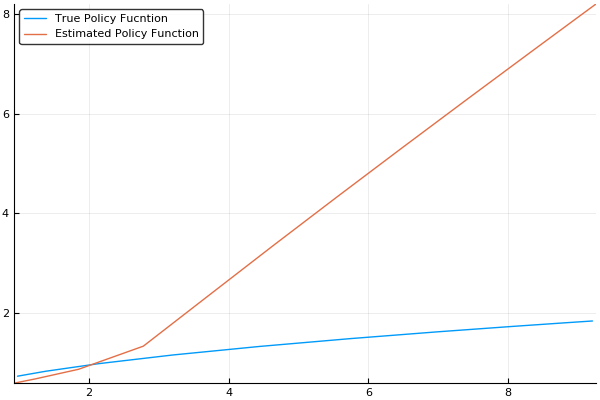

In [230]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, u_crra_prime_inv.((Ψprime * getvalue(θ))./(f_prime.(K, getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)), label="Estimated Policy Function")

The over/under-statement of returns to saving induces an error in the estimates!


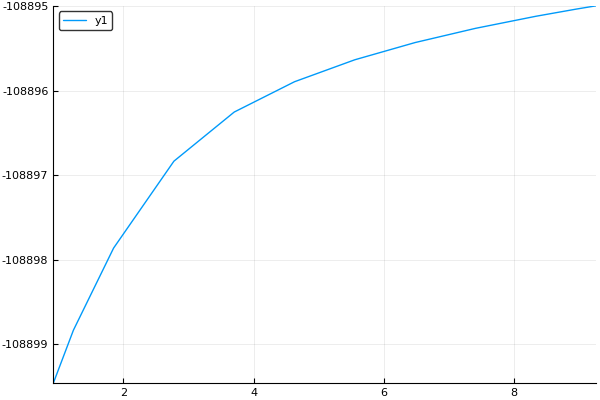

In [231]:
plot(K, Ψ * getvalue(θ))

With true deep parameters as starting value, but a guess for $\theta$, the algorithm does not find the solution.